In [ ]:
# ..... cell-cycle scoring ..... #

In [2]:
library(Seurat)
library(ggplot2)

In [3]:
# list of stages and samples
stages = rep(c('stage14', 'stage17', 'stage21'), each = 3)
samples = paste0('sample', c('4', '7', '8A', '3_Triangle', '5B', '5Y', '1A', '1B', '2'))

In [4]:
# load cell-cycle genes list
load('~/septation/cc.genes.rda')

# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [77]:
# load data
id = 9
file0 = paste0(stages[id], '_', samples[id], '_raw_data.rds')
sce = readRDS(file0)
sce

An object of class Seurat 
26985 features across 9682 samples within 1 assay 
Active assay: RNA (26985 features, 0 variable features)
 2 layers present: counts, data

In [78]:
# filter high MT cells
sce <- sce[,which(sce$mitoRatio<0.05)]

# remove low-expressed genes, cells with very low or very high UMI
sce <- sce[,which(sce$nFeature_RNA>150 & sce$nCount_RNA>150 & sce$nCount_RNA<12000)]

dim(sce)

[1] 26985  7551

In [79]:
# normalize data so that samples with many lowly-expressed genes can still return cell-cycle scores
# try min.cells = 1 if cell-cycle scoring still throws up error
sce <- NormalizeData(sce)

# Perform cell cycle scoring
sce <- CellCycleScoring(sce, g2m.features = g2m.genes, s.features = s.genes, set.ident = TRUE)
sce@meta.data[1,]

Warning message:
“The following features are not present in the object: MCM4, MLF1IP, NASP, SLBP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HJURP, HN1, NCAPD2, not searching for symbol synonyms”


orig.ident nCount_RNA nFeature_RNA
stage21_sample2_AAACCCAAGCAAATGT-1 stage21    1458       1053        
                                   mitoRatio  log10GenesPerUMI stage   sample 
stage21_sample2_AAACCCAAGCAAATGT-1 0.04938272 0.9553287        stage21 sample2
                                   S.Score     G2M.Score   Phase old.ident
stage21_sample2_AAACCCAAGCAAATGT-1 -0.07529657 -0.03640496 G1    stage21

In [80]:
# run pca on data
sce <- FindVariableFeatures(sce, selection.method = "vst")
sce <- ScaleData(sce, features = rownames(sce), verbose = FALSE)
sce <- RunPCA(sce, features = VariableFeatures(sce), verbose =  FALSE)

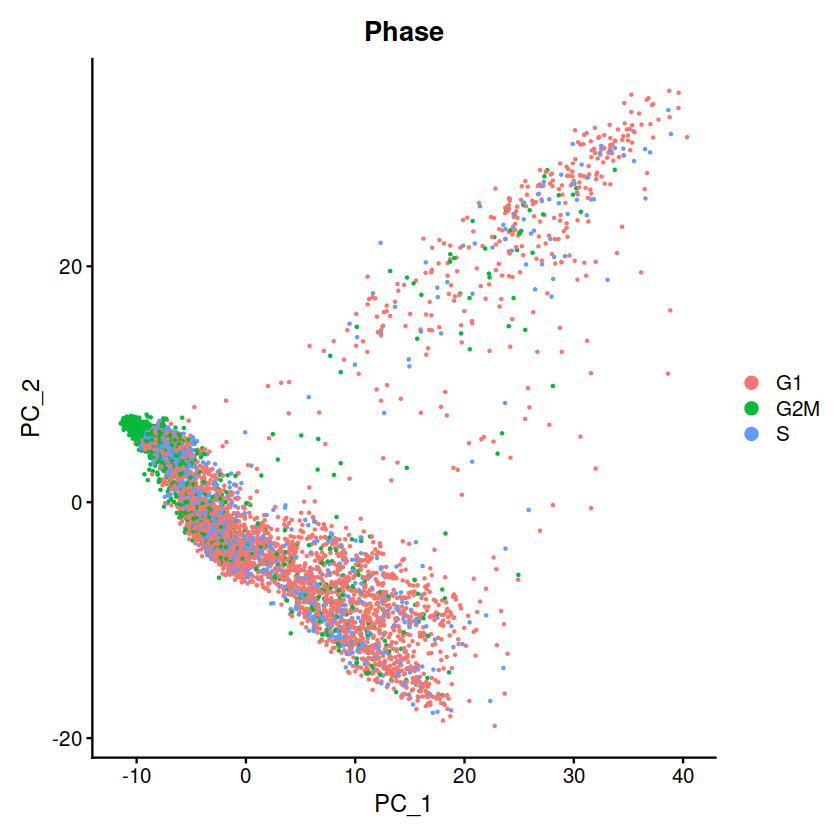

In [81]:
# Visualize the PCA, grouping by cell cycle phase
# png(paste0(stages[id], '_', samples[id], '_pca_cellcycle.png'), width = 8, height = 8, res = 300, units = 'in')
DimPlot(sce, reduction = "pca", group.by = "Phase")
# dev.off()

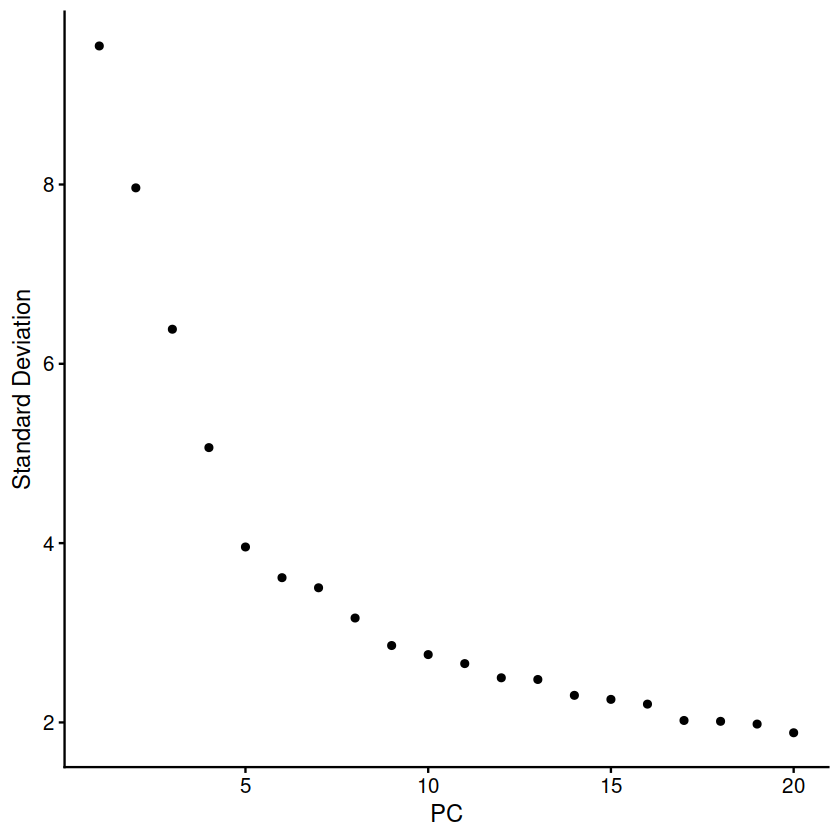

In [82]:
# elbow plot for num of PCs to choose
ElbowPlot(object = sce)

In [83]:
# cluster the data
sce <- FindNeighbors(sce, dims = 1:20, k = 30)
sce <- FindClusters(object = sce, resolution = 0.5, verbose = FALSE)

# run umap
sce <- RunUMAP(object = sce, dims = 1:20, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN



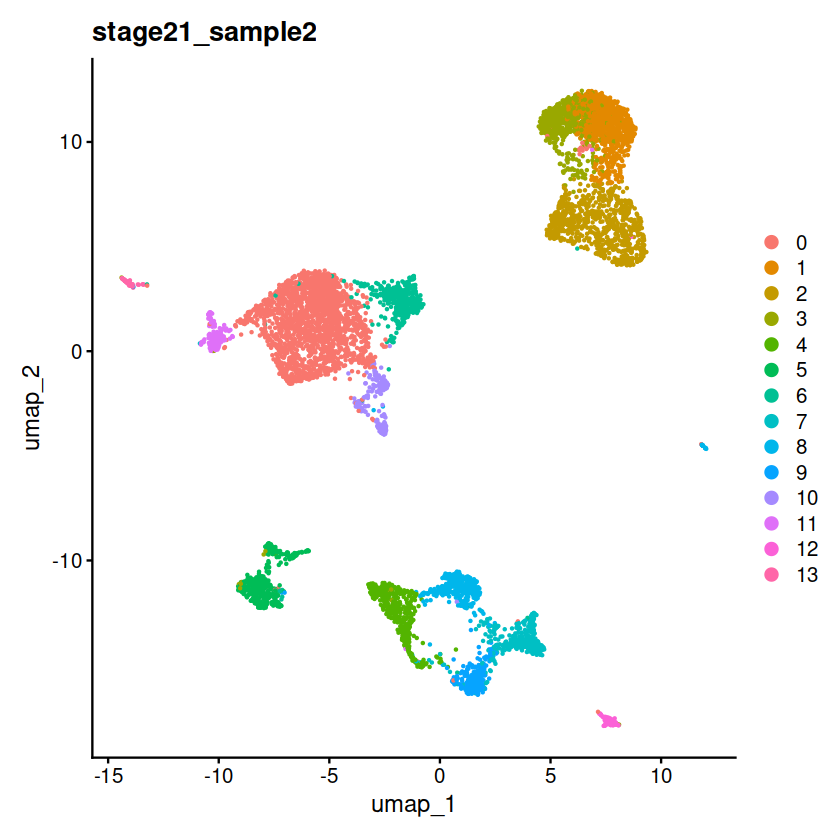

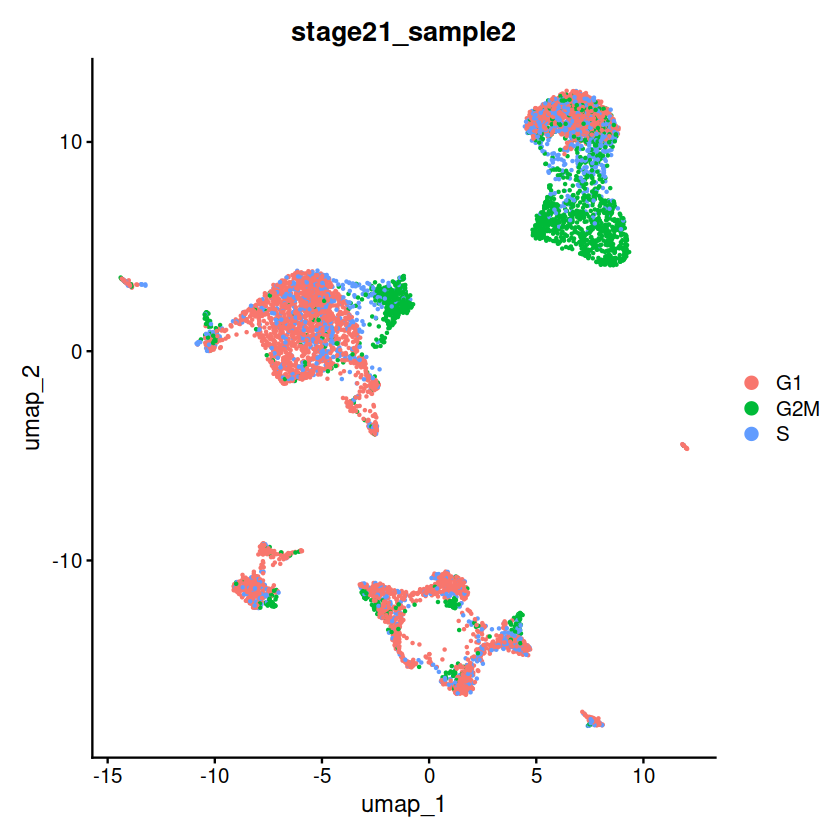

In [84]:
# plot umap
# png(paste0(stages[id], '_', samples[id], '_umap_clusters.png'), width = 8, height = 8, res = 300, units = 'in')
DimPlot(sce) + ggtitle(paste0(stages[id], '_', samples[id]))
# dev.off()

# png(paste0(stages[id], '_', samples[id], '_umap_cellcycle.png'), width = 8, height = 8, res = 300, units = 'in')
DimPlot(sce, reduction = 'umap', group.by = 'Phase') + ggtitle(paste0(stages[id], '_', samples[id]))
# dev.off()

In [85]:
# save file
saveRDS(sce, file = paste0(stages[id], '_', samples[id], '_data.rds'))